# Autoencoders Tutorial
From F. Chollet's blogs.keras.io
## Simple 1-hidden layer
1 dense layer as both encoder and decoder.
We will be working on MNIST dataset, i.e. 28 x 28 = 784 points in black and white

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Encoder on its own

In [2]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Decoder on its own

In [3]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

We define the loss as binary cross-entropy (pixel by pixel) and pick the Adadelta optimizer (works with Adam too)

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Now we read and prepare the MNIST digits data. We are not interested in labels (autoencoders are not supervised).
We scale the luminosity between 0.0 and 1.0, then flatten them into  784-element vectors

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


Train the autoencoder: input and target values are the same

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 106us/step - loss: 0.3624 - val_loss: 0.2709
Epoch 2/50
60000/60000 [==============================] - 6s 99us/step - loss: 0.2639 - val_loss: 0.2532
Epoch 3/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.2425 - val_loss: 0.2293
Epoch 4/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.2207 - val_loss: 0.2100
Epoch 5/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.2047 - val_loss: 0.1972
Epoch 6/50
60000/60000 [==============================] - 6s 98us/step - loss: 0.1939 - val_loss: 0.1882
Epoch 7/50
60000/60000 [==============================] - 6s 107us/step - loss: 0.1861 - val_loss: 0.1813
Epoch 8/50
60000/60000 [==============================] - 6s 100us/step - loss: 0.1798 - val_loss: 0.1756
Epoch 9/50
60000/60000 [==============================] - 6s 103us/step - loss: 0.1745 - val_loss: 0.1707


Let us encode a few images, decode them again and plot them for comparison

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

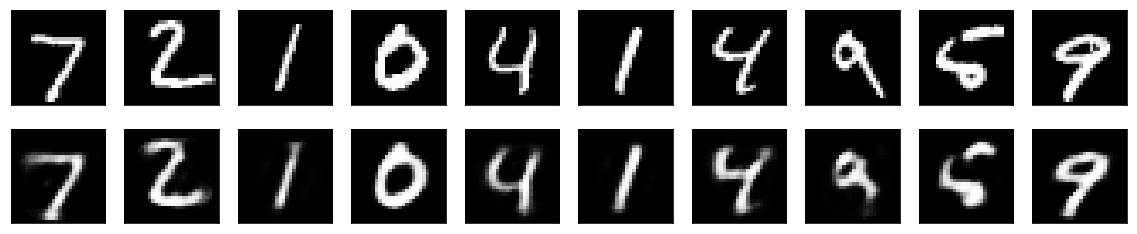

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Readable, but definitely "fuzzier". Let us add a sparsity constraint to our 32-D code. We can do so by introducing a L1 regularization term (penalizes large differences).

In [17]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

Let us compile, train the model again, then show the results.

In [19]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [21]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.3424 - val_loss: 0.3408
Epoch 2/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.3389 - val_loss: 0.3374
Epoch 3/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.3357 - val_loss: 0.3343
Epoch 4/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.3327 - val_loss: 0.3314
Epoch 5/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.3298 - val_loss: 0.3286
Epoch 6/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.3272 - val_loss: 0.3261
Epoch 7/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.3248 - val_loss: 0.3238
Epoch 8/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.3225 - val_loss: 0.3215
Epoch 9/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.3203 - val_loss: 0.3

In [22]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

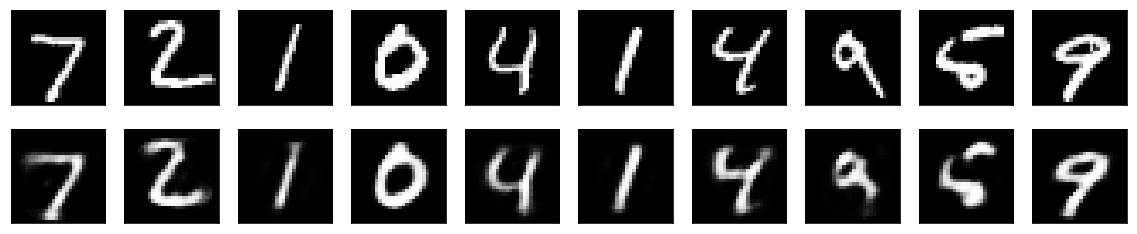

In [23]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Still fuzzy!

## Deep Autoencoder
Multiple layers, descending to 32-D gradually

In [24]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [25]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 133us/step - loss: 0.3320 - val_loss: 0.2641
Epoch 2/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.2553 - val_loss: 0.2445
Epoch 3/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.2312 - val_loss: 0.2192
Epoch 4/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.2131 - val_loss: 0.2029
Epoch 5/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1996 - val_loss: 0.1930
Epoch 6/100
60000/60000 [==============================] - 7s 112us/step - loss: 0.1898 - val_loss: 0.1833
Epoch 7/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.1819 - val_loss: 0.1773
Epoch 8/100
60000/60000 [==============================] - 7s 113us/step - loss: 0.1760 - val_loss: 0.1735
Epoch 9/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.1704 - val_

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

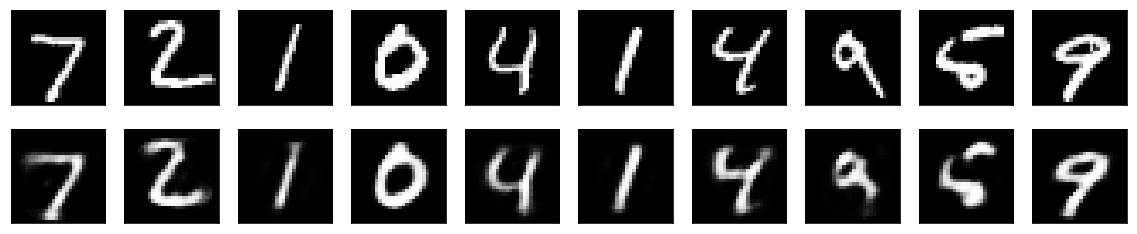

In [14]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional Autoencoders
Inputs and outputs are images. It makes sense to use convolution networks

In [26]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

No need to flatten with convolution network - we can use the original pictures

In [27]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

To see progress, start a tensorboard server with tensorboard --logdir=./logs, then open http://localhost:6006.
Note that tensorboard does slow things down a bit. Recommend use of GPU.

In [34]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='./logs')]
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 137s 2ms/step - loss: 0.1004 - val_loss: 0.0980
Epoch 2/20
60000/60000 [==============================] - 136s 2ms/step - loss: 0.1003 - val_loss: 0.1000
Epoch 3/20
60000/60000 [==============================] - 137s 2ms/step - loss: 0.1002 - val_loss: 0.1009
Epoch 4/20
60000/60000 [==============================] - 137s 2ms/step - loss: 0.0999 - val_loss: 0.0981
Epoch 5/20
60000/60000 [==============================] - 138s 2ms/step - loss: 0.0994 - val_loss: 0.0991
Epoch 6/20
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0992 - val_loss: 0.0989
Epoch 7/20
60000/60000 [==============================] - 137s 2ms/step - loss: 0.0991 - val_loss: 0.0985
Epoch 8/20
60000/60000 [==============================] - 138s 2ms/step - loss: 0.0990 - val_loss: 0.0995
Epoch 9/20
60000/60000 [==============================] - 137s 2ms/step - loss: 0.0989 - val_loss: 0.0

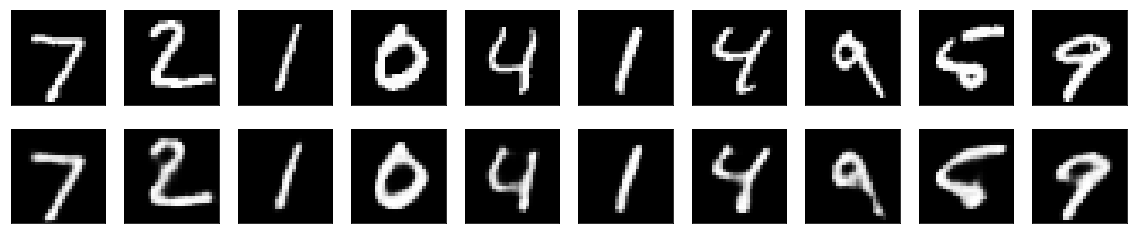

In [37]:
decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

A lot clearer!
Now let us have a look at the encoded images. They are tensors of 8x4x4, so we reshape them to 4x32 to display in 2D

In [47]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoded_imgs=encoder.predict(x_test)

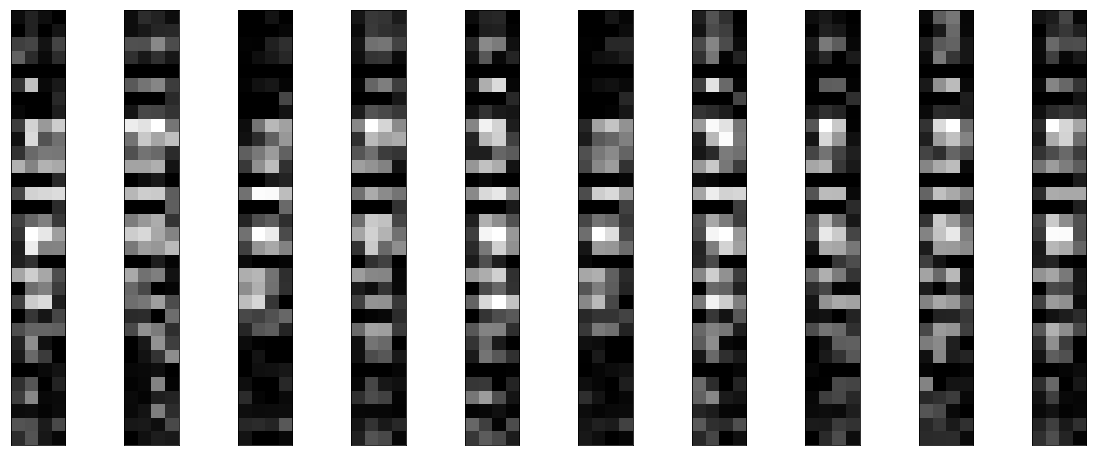

In [48]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4*8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising Autoencoders

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

In [ ]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [ ]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()